# Crunchbase Data Science Challenge

In [1]:
# Import dependencies & display configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 50)

In [2]:
# Data wrangling and featurization
pageviews = pd.read_csv("~/Desktop/data/pageviews.csv", 
                        index_col=0, 
                        parse_dates=[2]) \
    .rename(columns={'time': 'created_at'})
users = pd.read_csv("~/Desktop/data/users.csv", 
                    index_col=0, 
                    parse_dates=[2])

# Add created_at dates
users['created_at_date'] = pd.to_datetime(users.created_at.dt.strftime('%Y-%m-%d'))
pageviews['created_at_date'] = pd.to_datetime(pageviews.created_at.dt.strftime('%Y-%m-%d'))

# Verify the same user_ids exist in each dataset
assert pageviews.user_id.nunique() == users.user_id.nunique()
assert np.all(np.isin(pageviews.user_id.unique(), users.user_id.unique()))

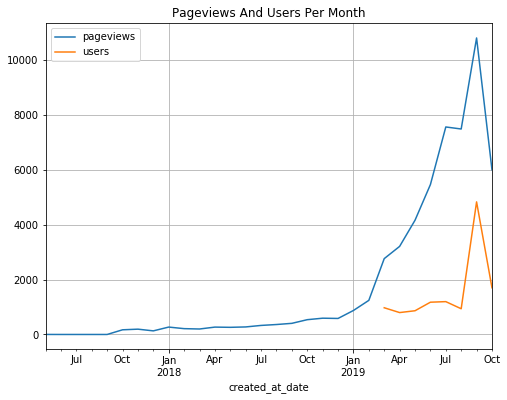

In [3]:
# Examine growth of datasets over time
pageviews.groupby('created_at_date').size().resample('M').sum().plot(grid=True, figsize=(8, 6), label='pageviews');
users.groupby('created_at_date').size().resample('M').sum().plot(grid=True, figsize=(8, 6), label='users');

plt.title('Pageviews And Users Per Month');
plt.legend();

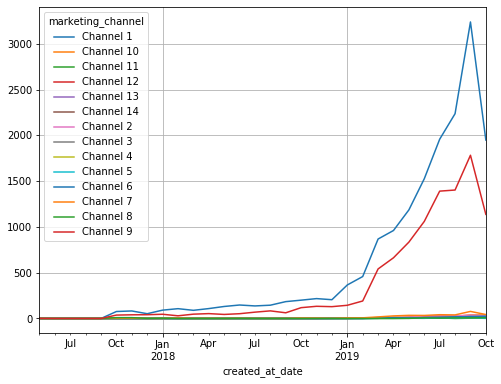

In [4]:
# Examine marketing channel of pageviews
pageviews[['created_at_date', 'user_id', 'marketing_channel']] \
    .drop_duplicates() \
    .groupby(['created_at_date', 'marketing_channel']).size() \
    .unstack('marketing_channel').resample('M').sum().plot(grid=True, figsize=(8,6));

In [5]:
# Check for missing data
print(f'pageviews shape = {pageviews.shape}')
print(f'users shape = {users.shape}')
print()

print(pageviews.isna().sum())
print()
print(users.isna().sum())

pageviews shape = (54285, 9)
users shape = (12461, 6)

user_id                 0
created_at              0
marketing_channel       0
path                    0
path_by_page_type    2257
path_by_domain          0
article_url             0
article_title           0
created_at_date         0
dtype: int64

user_id                0
created_at             0
job_function       10754
job_industry       10837
use_case            9919
created_at_date        0
dtype: int64


In [6]:
# Featurize pageviews
pageviews['website'] = pageviews.article_url.apply(lambda url: urlparse(url).netloc)
pageviews['page_rank'] = pageviews.groupby('user_id')['created_at'].rank('first')
pageviews['total_pageviews'] = pageviews.groupby('user_id')['page_rank'].transform('max')
pageviews['visit_number'] = pageviews.groupby('user_id')['created_at_date'].rank('dense')
pageviews['first_visit_date'] = pageviews.groupby('user_id')['created_at_date'].transform('min')

pageviews['user_cohort'] = pageviews.groupby('user_id')['created_at_date'].transform('min').dt.strftime('%Y-%m-01').map(pd.to_datetime)
pageviews['is_first_page'] = pageviews.page_rank == 1
pageviews['is_first_visit'] = pageviews.visit_number == 1
pageviews['num_visits'] = pageviews.groupby('user_id')['visit_number'].transform('max')
pageviews['last_visit_date'] = pageviews.groupby('user_id')['created_at_date'].transform('max')

pageviews = pd.merge(pageviews,
                     pageviews[pageviews.page_rank == 1][['user_id', 'marketing_channel']].drop_duplicates()
                     .rename(columns={'marketing_channel': 'acquisition_channel'}),
                     on='user_id',
                     how='left')

pageviews['days_since_first_visit'] = (pageviews.created_at_date - pageviews.first_visit_date).dt.days
pageviews['customer_lifetime'] = (pageviews.last_visit_date - pageviews.first_visit_date).dt.days

In [7]:
# Examine effect of marketing chanel on customer lifetime
pageviews[['user_id', 'acquisition_channel', 'customer_lifetime']].drop_duplicates() \
    .groupby('acquisition_channel').customer_lifetime.describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
acquisition_channel,,,,,,,,
Channel 1,8173.0,37.104735,97.411765,0.0,0.0,0.0,16.00,736.0
Channel 9,3600.0,36.360000,96.062216,0.0,0.0,0.0,18.00,735.0
Channel 7,163.0,30.588957,91.111161,0.0,0.0,0.0,7.00,696.0
Channel 10,104.0,20.923077,48.268000,0.0,0.0,0.0,9.50,222.0
Channel 2,102.0,9.980392,26.090467,0.0,0.0,0.0,5.75,179.0
Channel 12,64.0,28.890625,60.112624,0.0,0.0,1.0,43.00,345.0
Channel 14,53.0,27.188679,60.691546,0.0,0.0,0.0,19.00,317.0
Channel 3,50.0,12.360000,38.588758,0.0,0.0,0.0,0.00,242.0
Channel 13,48.0,6.583333,16.052882,0.0,0.0,0.0,1.50,87.0


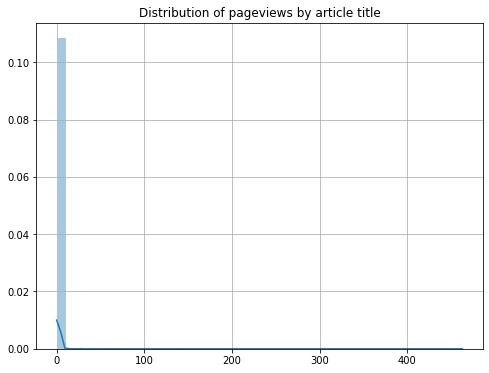

In [8]:
# Examine frequency of each article viewe
plt.figure(figsize=(8, 6))
sns.distplot(pageviews.groupby('article_title').size())
plt.grid()
plt.title('Distribution of pageviews by article title');

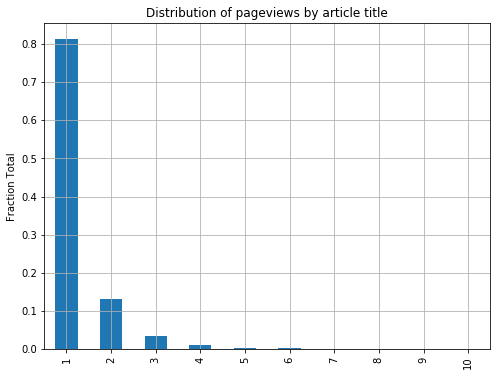

In [9]:
# Most articles have only been viewed once
pageviews.groupby('article_title').size().value_counts(normalize=True) \
    .head(10).plot(kind='bar', grid=True, figsize=(8, 6));
plt.title('Distribution of pageviews by article title');
plt.ylabel('Fraction Total');

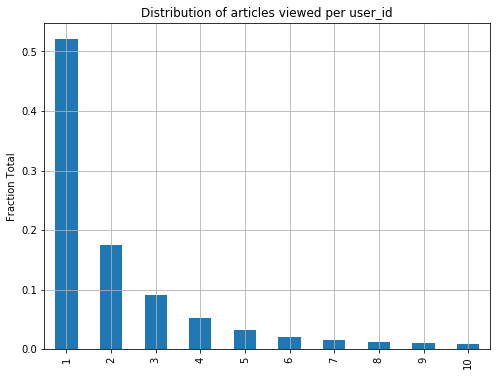

In [10]:
# Most users only view one article
pageviews.groupby('user_id').article_title.nunique().value_counts(normalize=True).head(10) \
    .plot(kind='bar', grid=True, figsize=(8, 6));
plt.title('Distribution of articles viewed per user_id');
plt.ylabel('Fraction Total');

In [11]:
# Examine user retention

def get_retention_cohort(val):
    dayz = [0, 30, 60, 90, 120, 180, np.inf]
    for day in dayz:
        if val <= day:
            return day


pageviews['retention_cohort'] = pageviews.days_since_first_visit.map(get_retention_cohort)

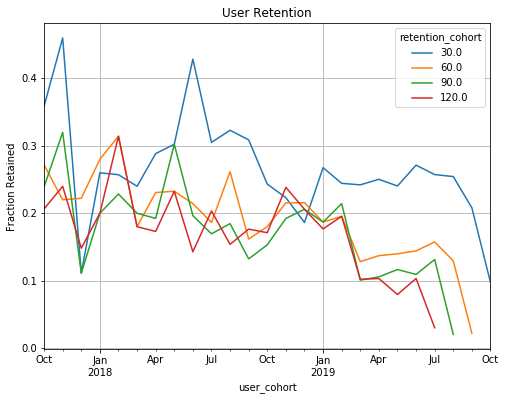

In [12]:
df = pageviews.groupby(['user_cohort', 'retention_cohort'])['user_id'].nunique().unstack('retention_cohort')
cohortz = df.loc[:, 0.0].copy()

df_2 = df.loc[:, 30.0:120.0].div(cohortz.values, axis=0)
df_2['2017-07':].plot(grid=True, figsize=(8,6));
plt.title('User Retention');
plt.ylabel('Fraction Retained');

In [13]:
# Apply 30-day Half-Life to pageviews
HALF_LIFE = 30

pageviews['delta_t'] = (pageviews.created_at_date.max() - pageviews.created_at_date).dt.days
pageviews['page_value'] = pageviews.delta_t.map(lambda val: 0.5**(val / HALF_LIFE))
pageviews['num_title_words'] = pageviews.article_title.map(lambda title: len(title.split(' ')))

In [14]:
# Featurize pageviews using article title
N_FEATURES = 512

vectorizer = HashingVectorizer(stop_words='english',
                               ngram_range=(1, 2),
                               strip_accents='unicode',
                               n_features=N_FEATURES)

# Build Feature Matrix
In this step, we will build a feature matrix for each user, using the hashing vectorizer and the page values computed with HALF_LIFE variable

In [15]:
# inititalize dataframe with article titles and hash titles
df = pd.DataFrame(data=pageviews.article_title.drop_duplicates())
df_2 = pd.DataFrame(vectorizer.fit_transform(df['article_title']).toarray()).set_index(df.article_title.values)

# Keep page value which is reflection of HALF_LIFE
df_3 = pageviews[['user_id', 'article_title', 'page_value']].copy()

df_4 = pd.merge(df_3, df_2, left_on='article_title', right_index=True, how='left') \
    .drop(columns=['article_title']) \
    .set_index(['user_id', 'page_value'])

df_5 = df_4.multiply(df_4.index.get_level_values('page_value'), axis=0) \
    .reset_index().drop(columns=['page_value'])

# For each user, just average the features
df_6 = df_5.groupby('user_id').mean()

df_6.iloc[:5, :10]

,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
0005f1a8-2fed-4ddf-912e-25c4b09832ea,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
0015c201-e502-46b3-8a1d-65c03cb1d94f,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
0015cfcd-ed7b-4a16-b88b-fd33d3fa2d74,0.00000,0.0,0.0,0.000000,0.000457,0.0,0.0,0.000000,0.0,0.0
0019a789-9744-4efd-8f45-c9c37cb12fdd,-0.00179,0.0,0.0,-0.001314,0.000000,0.0,0.0,-0.001579,0.0,0.0
002dd14d-3412-46bc-affb-f374f810c7fc,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [16]:
# Normalize each row to have unit norm and compute gram matrix (cosine similarity)

user_matrix = pd.DataFrame(index=df_6.index, data=Normalizer().fit_transform(df_6))
gram_matrix = pd.DataFrame(index=user_matrix.index, 
                           columns=user_matrix.index.values, 
                           data=cosine_similarity(user_matrix))

# Gram Matrix
This data structure contains the cosine similarities between every user. Different distance metrics (such as Euclidean distance) could also be tested.

In [17]:
gram_matrix.iloc[:5, :5]

,0005f1a8-2fed-4ddf-912e-25c4b09832ea,0015c201-e502-46b3-8a1d-65c03cb1d94f,0015cfcd-ed7b-4a16-b88b-fd33d3fa2d74,0019a789-9744-4efd-8f45-c9c37cb12fdd,002dd14d-3412-46bc-affb-f374f810c7fc
user_id,,,,,
0005f1a8-2fed-4ddf-912e-25c4b09832ea,1.000000,0.000000,0.071067,0.000000,-0.009277
0015c201-e502-46b3-8a1d-65c03cb1d94f,0.000000,1.000000,0.000000,-0.039562,0.000000
0015cfcd-ed7b-4a16-b88b-fd33d3fa2d74,0.071067,0.000000,1.000000,0.035785,0.073727
0019a789-9744-4efd-8f45-c9c37cb12fdd,0.000000,-0.039562,0.035785,1.000000,0.059270
002dd14d-3412-46bc-affb-f374f810c7fc,-0.009277,0.000000,0.073727,0.059270,1.000000


# Recommendation Algorithm

In [18]:
# Get Recommendations
user_id = users.sample(1)['user_id'].values[0]
print(f'user_id = {user_id}')

user_article_titles = pageviews[pageviews.user_id == user_id].article_title.unique()
print(user_article_titles)

similarity_values = gram_matrix.loc[user_id].to_frame('user_similarity')
page_values = pd.merge(pageviews[['user_id', 'article_title', 'page_value']].copy(), similarity_values,
                       left_on='user_id', right_index=True, how='left')
page_values['score'] = page_values.page_value * page_values.user_similarity

recs = page_values.groupby('article_title').score.mean().sort_values(ascending=False).to_frame('score')

mask = np.isin(recs.index.values, np.array(user_article_titles))
recs = recs[~mask]
print(recs)

user_id = ac1f1878-c71d-4276-bb27-486e945f0f96
['Indoor farming startup Infarm raises $25 million Series A round']
                                                       score
article_title                                               
Dutch cleantech startup ViriCiti raises €6.25 m...  0.428742
Washmen raises $6.2 million Series B                0.358304
Access 360 Media Secures $12M Funding Round Led...  0.346436
Bolstra Secures $1.5M in Seed Funding               0.343674
Carmel software firm lands $1.5M in VC from big...  0.343674
...                                                      ...
科技公司Zapier前往双城                                     -0.160008
S | W：SaaS周刊– Slack幻灯片                             -0.160008
商业选择奖”：项目管理和业务团队消息工具                               -0.160008
Josh Brown）喜欢松弛                                    -0.160008
Austin-focused VC fund eyes $20M                   -0.176879

[41292 rows x 1 columns]


                                                       score
article_title                                               
Dutch cleantech startup ViriCiti raises €6.25 m...  0.428742
Washmen raises $6.2 million Series B                0.358304
Access 360 Media Secures $12M Funding Round Led...  0.346436
Bolstra Secures $1.5M in Seed Funding               0.343674
Berlin-based IoT startup EMnify raises €8 milli...  0.342274
Financial management startup Finch raises $2.25...  0.339978
Fabmatics zieht erste Zwischenbilanz nach Fusion    0.335825
Ceat Limited (Parent)                               0.332255
FinSMEs | Patreon Raises $2.1M                      0.328155
Gymlib annonce une levée de fonds de 10 million...  0.327492
Trust & Will closes first electronic will in th...  0.321830
Dugout Raises £8.275M in Funding                    0.320012
Newgen KnowledgeWorks buys majority stake in Ex...  0.315853
Acronis Announces a $147 Million Investment Rou...  0.308015
DecaWave raises 2802800 

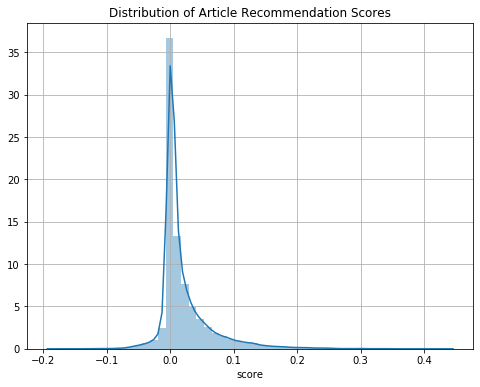

In [19]:
# Remove articles that are very similar
recs_2 = recs.drop_duplicates(subset='score')
print(recs_2.head(15))

# Plot distribution of article scores
plt.figure(figsize=(8, 6))
sns.distplot(recs_2.score);
plt.title('Distribution of Article Recommendation Scores');
plt.grid()

# Summary and Next Steps